# Machine Learning for Wind Power Forecasting

This notebook implements multiple models for wind power forecasting. The first uses a one-step model based on a Random Forest (RF) regressor that predicts the wind power at the next time step based on a past hour of power outputs. The second uses a multi-step (recursive autoregressive) model to predict an hour ahead in 10min increments based on a past hour of power outputs. The results show that high autocorrelation of wind power results in an autoregressive model that performs slightly better with a linear regressor than it does with RF.  

In [202]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from albatross.analysis import plot_windrose, boxplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import arviz as az
import os
import cmdstanpy
from cmdstanpy import cmdstan_path, CmdStanModel

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

In [203]:
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.31.0
Install directory: /home/cam/.cmdstan
CmdStan version 2.31.0 already installed


True

In [204]:
# cmap = mpl.colormaps['tab10']
az.style.use("arviz-docgrid")

## Data

The data consists of two years (2019-2020) of Wind Turbine data from the Kelmarsh Wind Farm in the UK.

Plumley, Charlie. Kelmarsh Wind Farm Data. Zenodo, 1 Feb. 2022. Zenodo, https://doi.org/10.5281/zenodo.5841834.


In [205]:
# TODO: Use full farm data in analysis (currently using one turbine).

# DATA_DIRS = ['../data/Kelmarsh_SCADA_2019/', '../data/Kelmarsh/SCADA_2020']

# FNAMES = [
#     "Turbine_Data_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv",
    # "Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv",
    # "Turbine_Data_Kelmarsh_3_2020-01-01_-_2021-01-01_230.csv",
    # "Turbine_Data_Kelmarsh_4_2020-01-01_-_2021-01-01_231.csv",
    # "Turbine_Data_Kelmarsh_5_2020-01-01_-_2021-01-01_232.csv",
    # "Turbine_Data_Kelmarsh_6_2020-01-01_-_2021-01-01_233.csv",
# ]

# turbines = []

# for i, _ in enumerate(FNAMES):
#     fname = DATA_DIRS[0] + FNAMES[i]
#     print(f"Loading data: {FNAMES[i]}")
#     wt = pd.read_csv(fname, header=9)
#     turbines.append(wt)

wt_2019 = pd.read_csv("../data/Kelmarsh_SCADA_2019/Turbine_Data_Kelmarsh_1_2019-01-01_-_2020-01-01_228.csv", header=9)
wt_2020 = pd.read_csv("../data/Kelmarsh_SCADA_2020/Turbine_Data_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv", header=9)

wt_raw = pd.concat([wt_2019, wt_2020])

In [206]:
wt_raw.columns[wt_raw.columns.str.contains("power")]

Index(['Potential power default PC (kW)', 'Potential power learned PC (kW)',
       'Potential power reference turbines (kW)',
       'Cascading potential power (kW)',
       'Cascading potential power for performance (kW)',
       'Potential power met mast anemometer (kW)',
       'Potential power primary reference turbines (kW)',
       'Potential power secondary reference turbines (kW)',
       'Potential power estimated (kW)', 'Potential power MPC (kW)',
       'Potential power met mast anemometer MPC (kW)', 'Reactive power (kvar)',
       'Reactive power, Max (kvar)', 'Reactive power, Min (kvar)',
       'Reactive power, Standard deviation (kvar)', 'Apparent power (kVA)',
       'Apparent power, Max (kVA)', 'Apparent power, Min (kVA)',
       'Apparent power, StdDev (kVA)'],
      dtype='object')

In [207]:
wt = wt_raw.loc[:, ["# Date and time", "Power (kW)", "Wind direction (°)", "Wind speed (m/s)"]]
wt = wt.rename(columns={"# Date and time": "Date", "Power (kW)": "Power", "Wind direction (°)": "Wind direction", "Wind speed (m/s)": "Wind speed"})
wt["Date"] = pd.to_datetime(wt["Date"].astype("datetime64"))
wt = wt.set_index("Date")
wt = wt.asfreq("10min")

wt["Power"].bfill(inplace=True)
wt["Wind direction"].bfill(inplace=True)
wt["Wind speed"].bfill(inplace=True)
# wt["Power"] = wt["Power"].transform(lambda p: max(p, 0))
wt = wt.sort_index()

wt.head()

,Power,Wind direction,Wind speed
Date,,,
2019-01-01 00:00:00,191.814896,284.644043,4.454060
2019-01-01 00:10:00,189.524963,288.776154,4.331436
2019-01-01 00:20:00,381.144653,292.093292,5.447210
2019-01-01 00:30:00,422.717590,294.645264,5.472900
2019-01-01 00:40:00,307.518646,299.022400,5.601278


In [208]:
# check timeseries format
(wt.index == pd.date_range(start=wt.index.min(),
                             end=wt.index.max(),
                             freq=wt.index.freq)).all()

True

In [209]:
wt.describe()

,Power,Wind direction,Wind speed
count,105264.000000,105264.000000,105264.000000
mean,658.230309,200.768777,6.298800
std,645.270553,90.442918,2.883361
min,-17.846463,0.007310,0.134232
25%,125.766387,143.144123,4.226321
50%,431.540100,218.771682,6.025231
75%,1035.737753,261.830924,7.927109
max,2081.028912,359.996088,22.419562


In [210]:
# ensure no null values
len(wt[wt["Power"].isnull()]) == 0

True

In [211]:
speed = wt.loc[:, "Wind speed"]
direction = wt.loc[:, "Wind direction"]
active_power = wt.loc[:, "Power"]

The wind speed distribution represents a typical right-skewed distribution, where we see the highest counts around 5-6 m/s

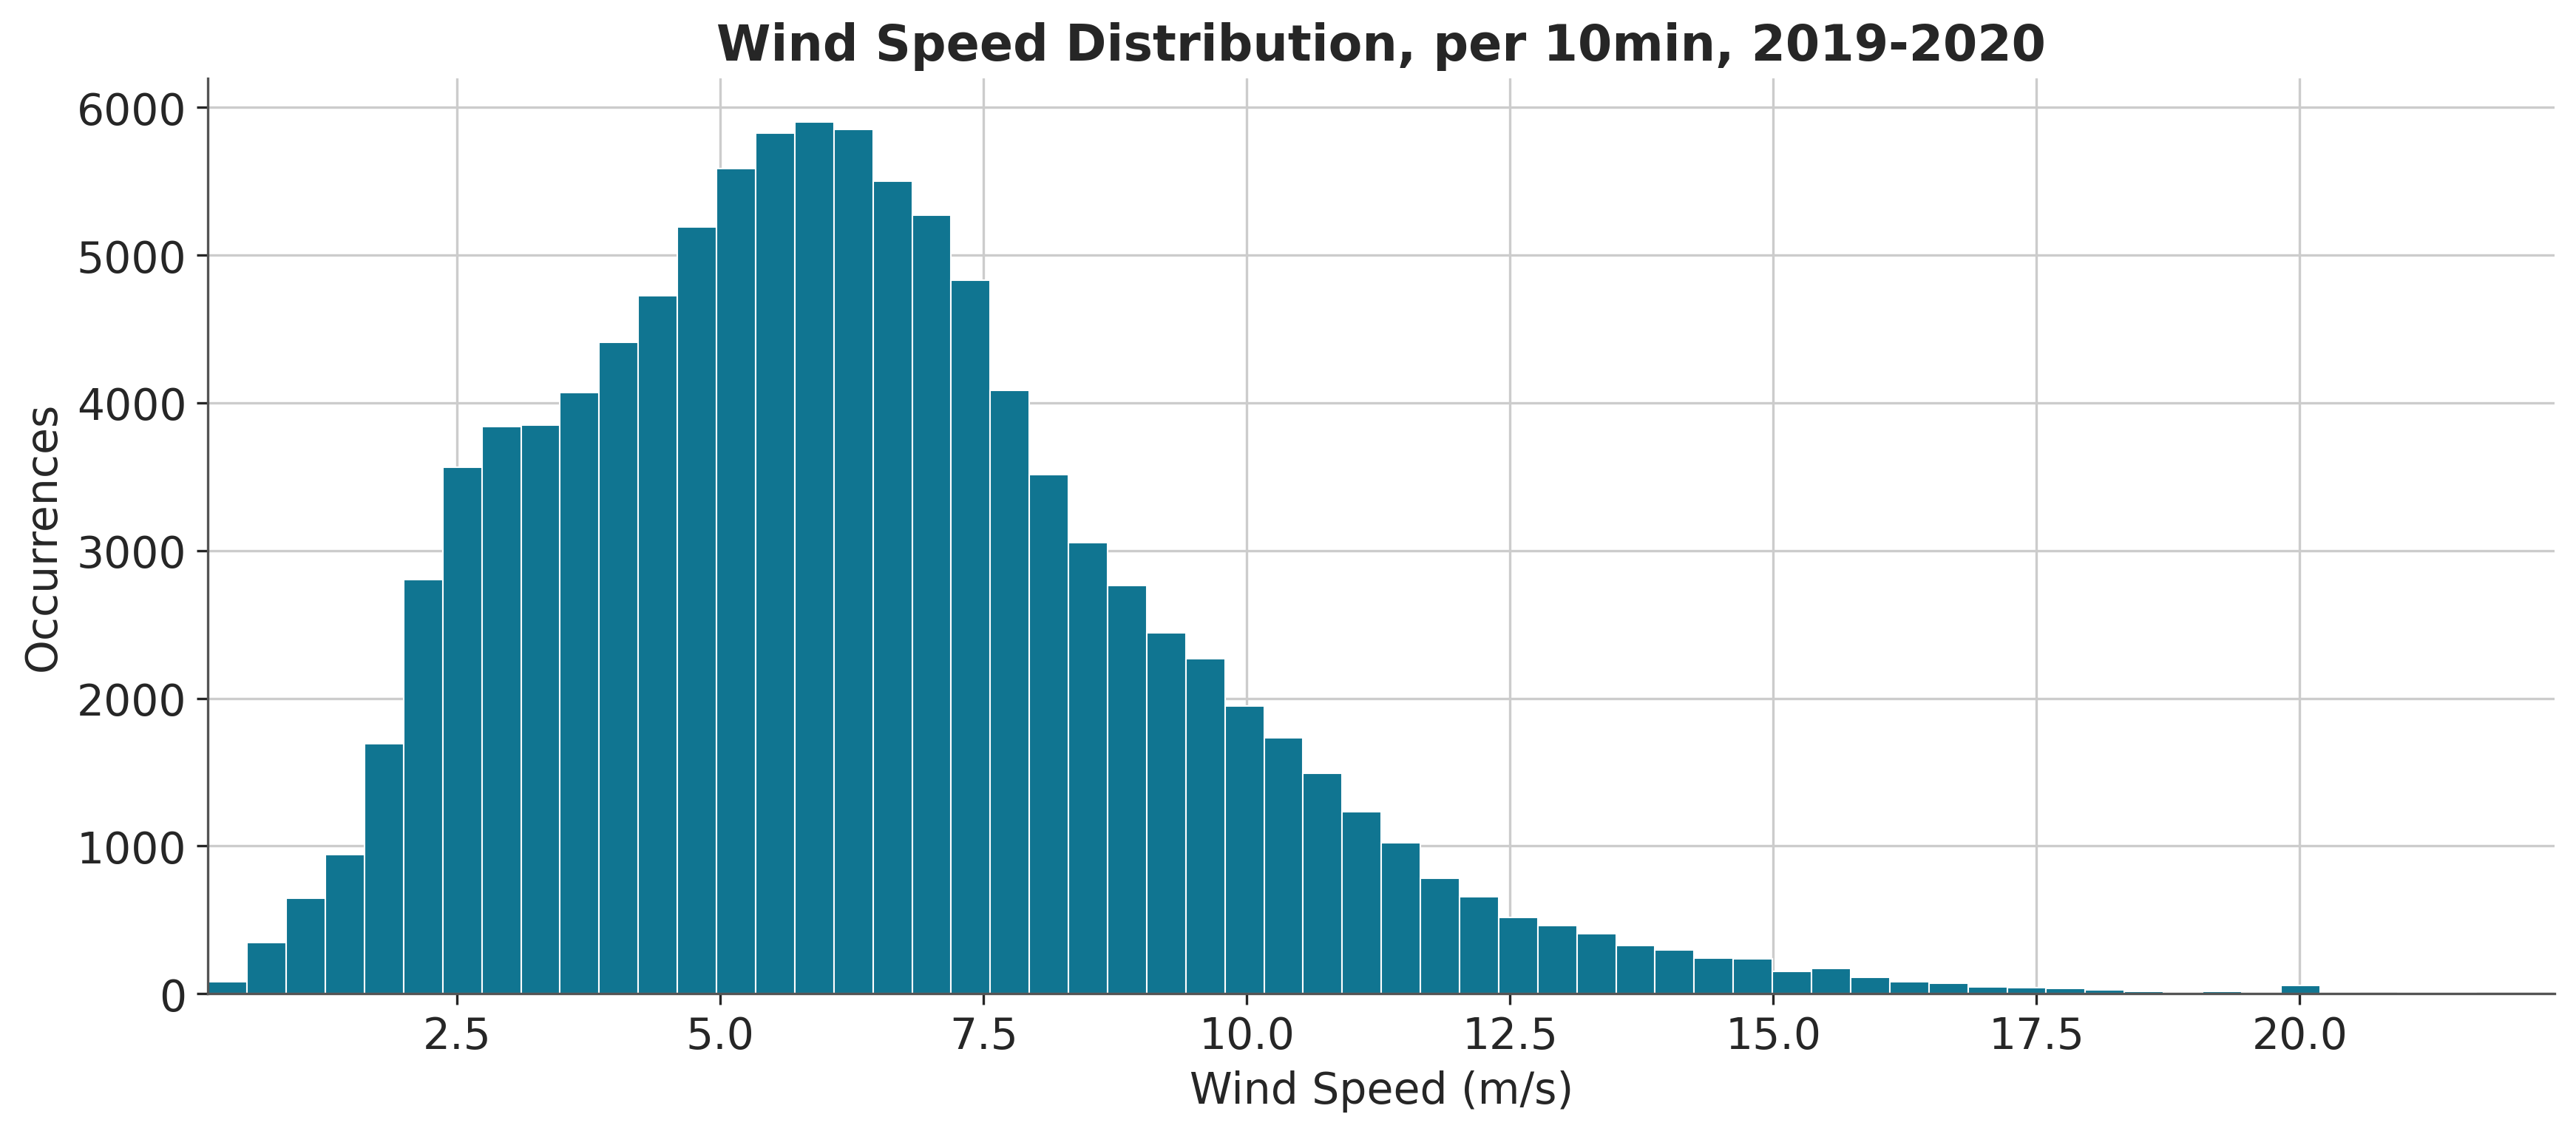

In [212]:
fig, ax = plt.subplots()

ax.set_title("Wind Speed Distribution, per 10min, 2019-2020")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Occurrences")
ax.set_xmargin(0)
ax.hist(speed, 60, linewidth=0.5, edgecolor="white")
ax.grid(True)

#fig.savefig("ws_distribution.png")

A wind rose is a useful visualization that simultaneously characterizes wind speed and wind direction. The magnitude of a spoke represents the percentage of time in that direction. In this one we see that the predominant wind direction is SW.

<WindroseAxes: >

/home/cam/workspace/projects/REStats/env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/cam/workspace/projects/REStats/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


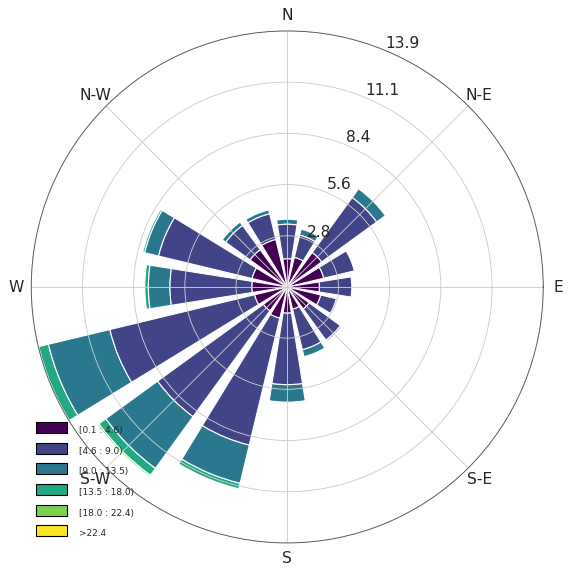

In [213]:
plot_windrose(wt, speed="Wind speed", direction="Wind direction")

We can also look at wind speed vs power output. We see that there is a strong correlation between the two, which is expected. There's an exception here in the middle of the day, where the power drops to zero. It looks like the turbine cut-in speed is around 2 m/s, meaning that it will shut off below that wind speed.

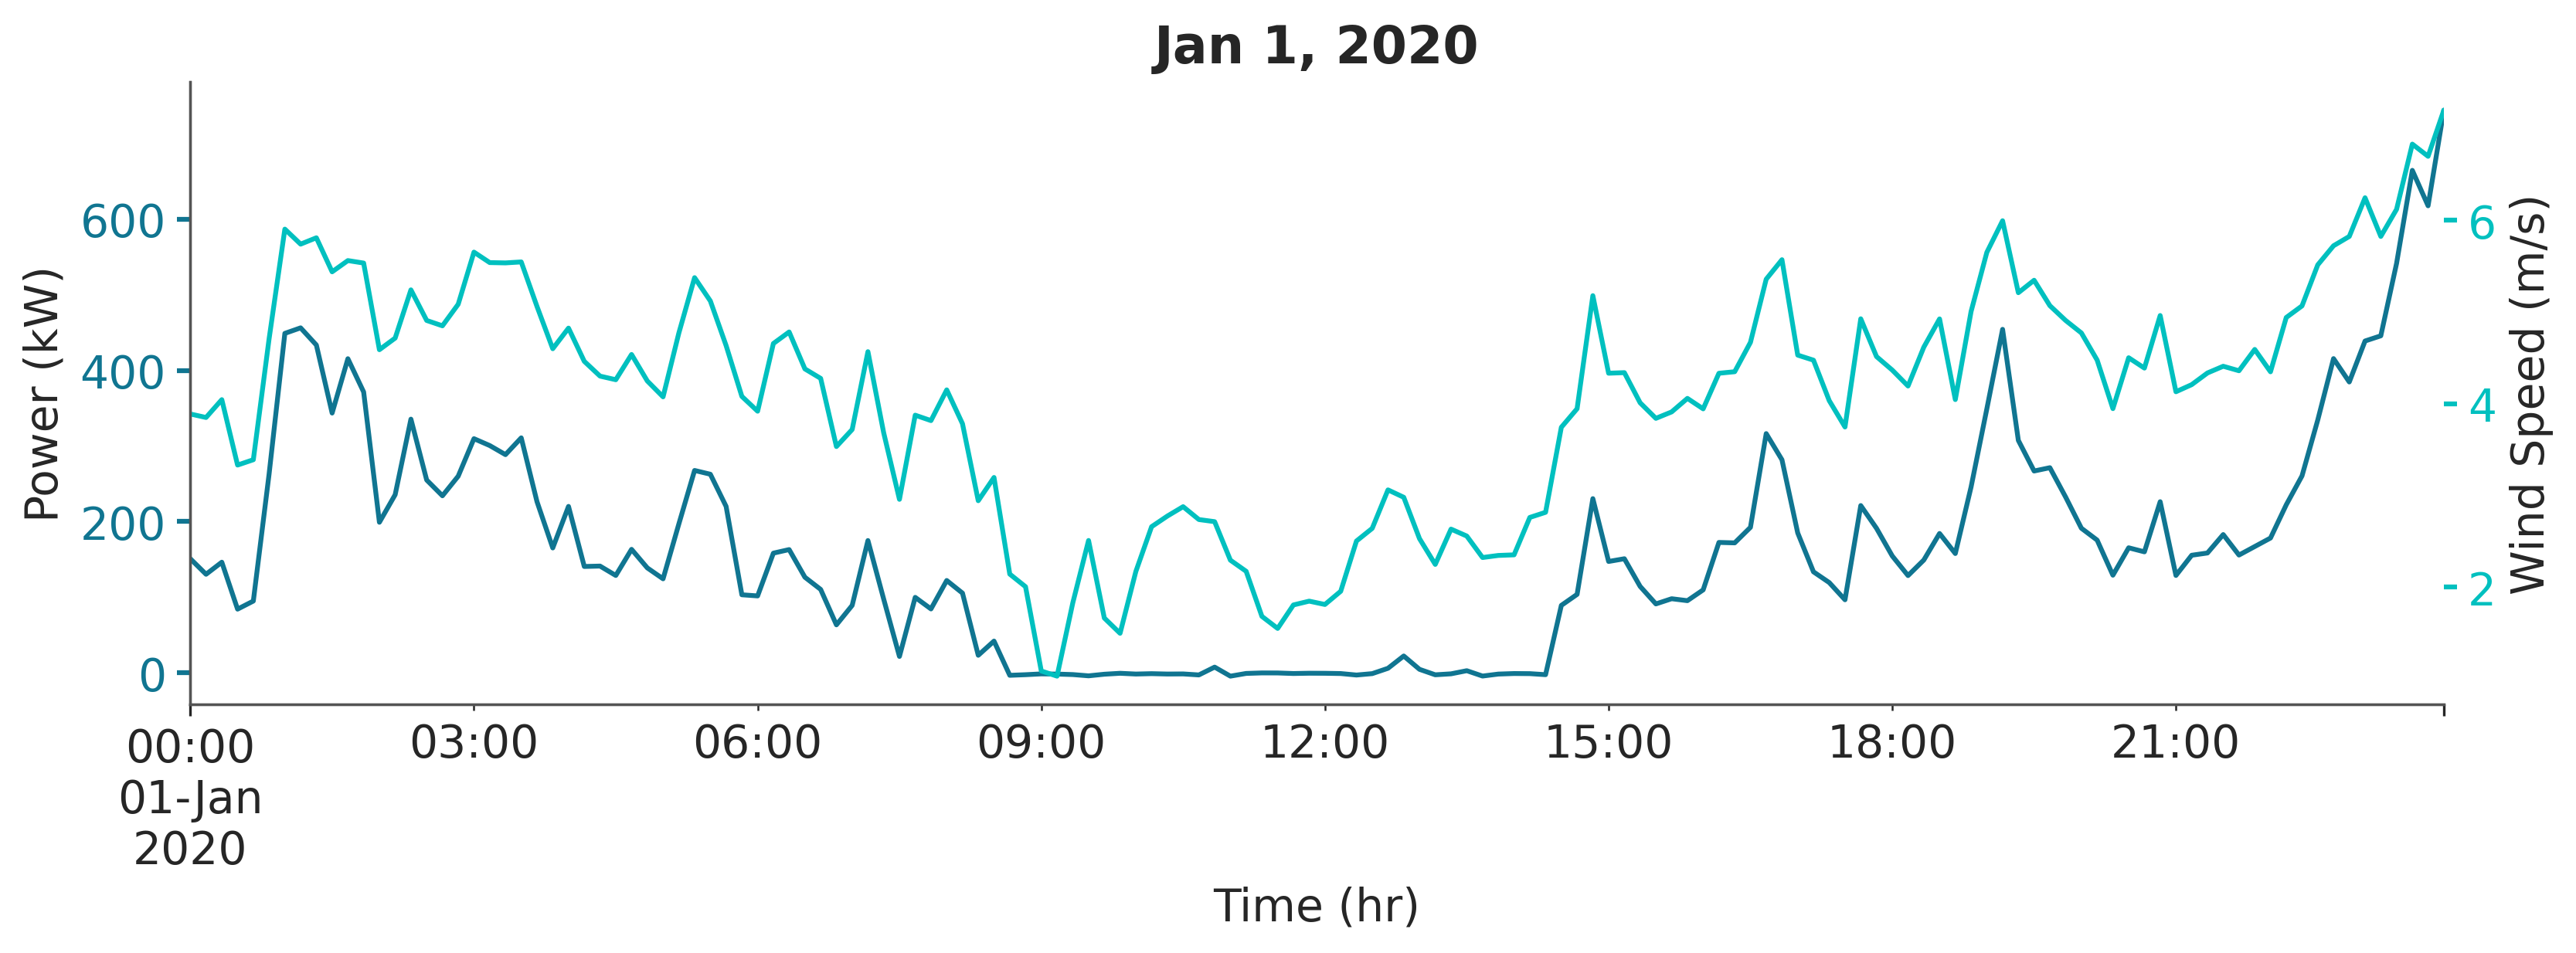

In [214]:
wt_1day = wt.loc[(wt.index >= "2020-01-01") & (wt.index < "2020-01-02")]

fig, ax = plt.subplots(figsize=(11, 4))

wt_1day["Power"].plot(ax=ax, color="C0")
right_ax = ax.twinx()
wt_1day["Wind speed"].plot(ax=right_ax, color="C1")

ax.grid(False)
right_ax.grid(False)
right_ax.axis('on')

ax.set_title("Jan 1, 2020")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)
right_ax.set_xmargin(0)
ax.set_xlabel("Time (hr)")
ax.tick_params(axis='y', colors="C0", size=4, width=1.5)
right_ax.set_ylabel("Wind Speed (m/s)")
right_ax.tick_params(axis='y', colors="C1", size=4, width=1.5)

#fig.savefig("p_ws.png")

If we plot all of the observations of wind speed vs power, we get a representation of the turbine's power curve. As we saw before, it appears that the cut-in speed is around 2 m/s, and the rated power is around 2000 kW, or 2 MW. The turbine controls will prevent it from attempting to produce beyond that point, so the curve levels off at that power. Finally, we see that the cut-out speed is around 20 m/s, where the turbine will shut down to prevent damage from high winds.

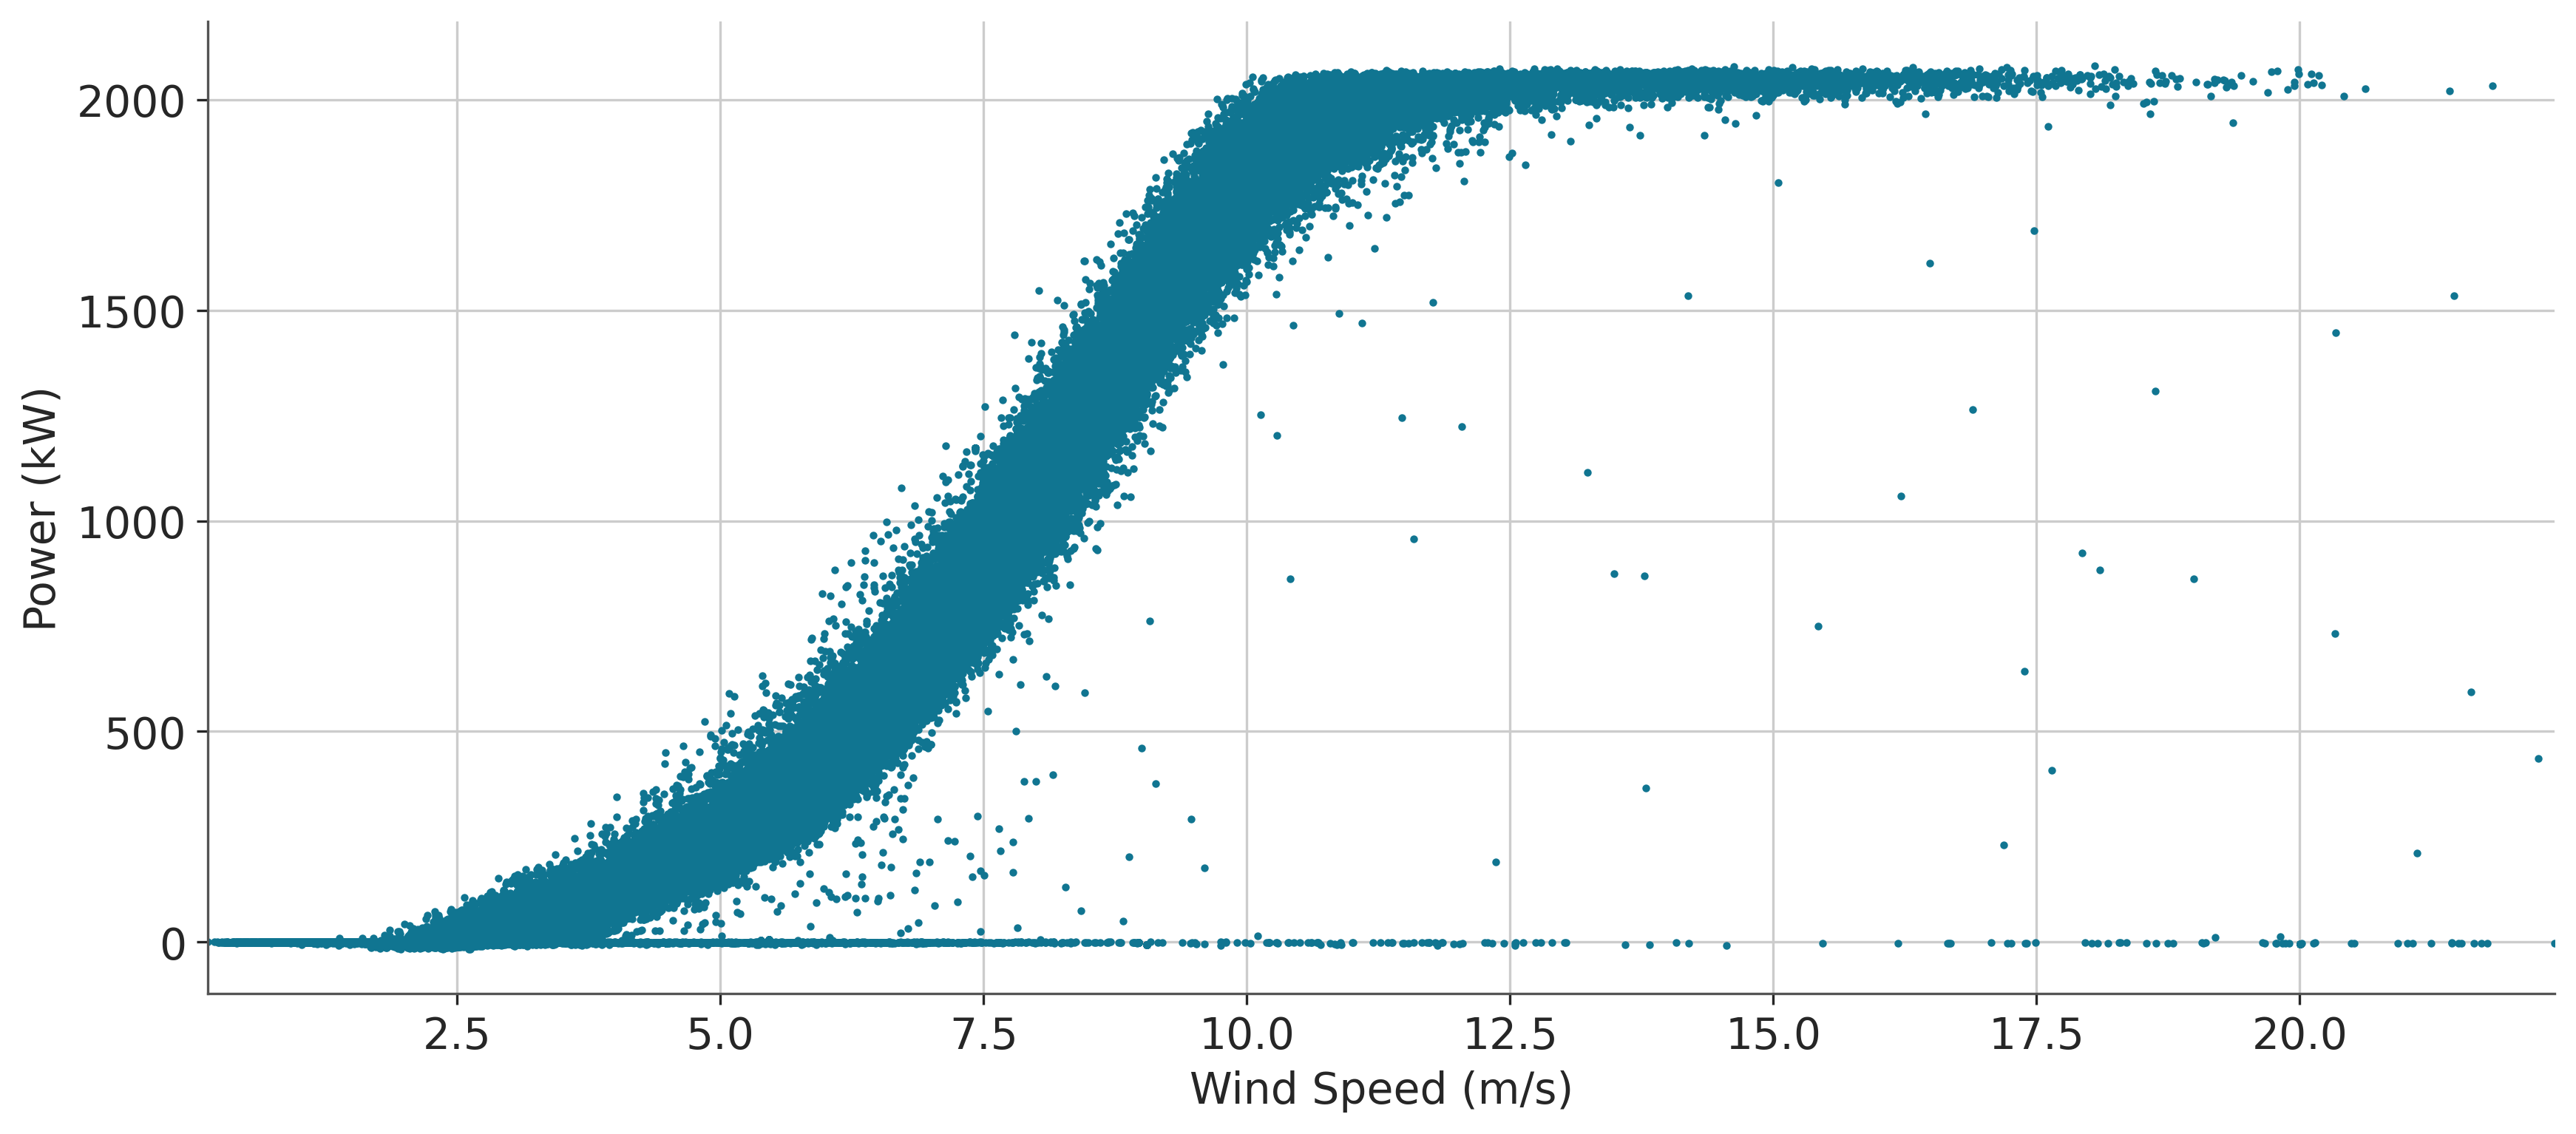

In [215]:
fig, ax = plt.subplots()
ax.plot(speed, active_power, "o", markersize=1.5)
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)

# fig.savefig("power_curve.png")

This information is useful, but in order to form a forecasting model, we need to determine a feature set that incorporates an intuition about the past so that we can predict the future. One way to look at this is through autocorrelation: how does past power correlate with current power? We can explore this by calculating the correlation coefficients of current power with its past values, also called "lags". We see from the plot that current power is highly correlated with past power, up to a certain point. With this knowledge, we can attempt to build a model that uses these lags themselves as features!

/home/cam/workspace/projects/REStats/env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


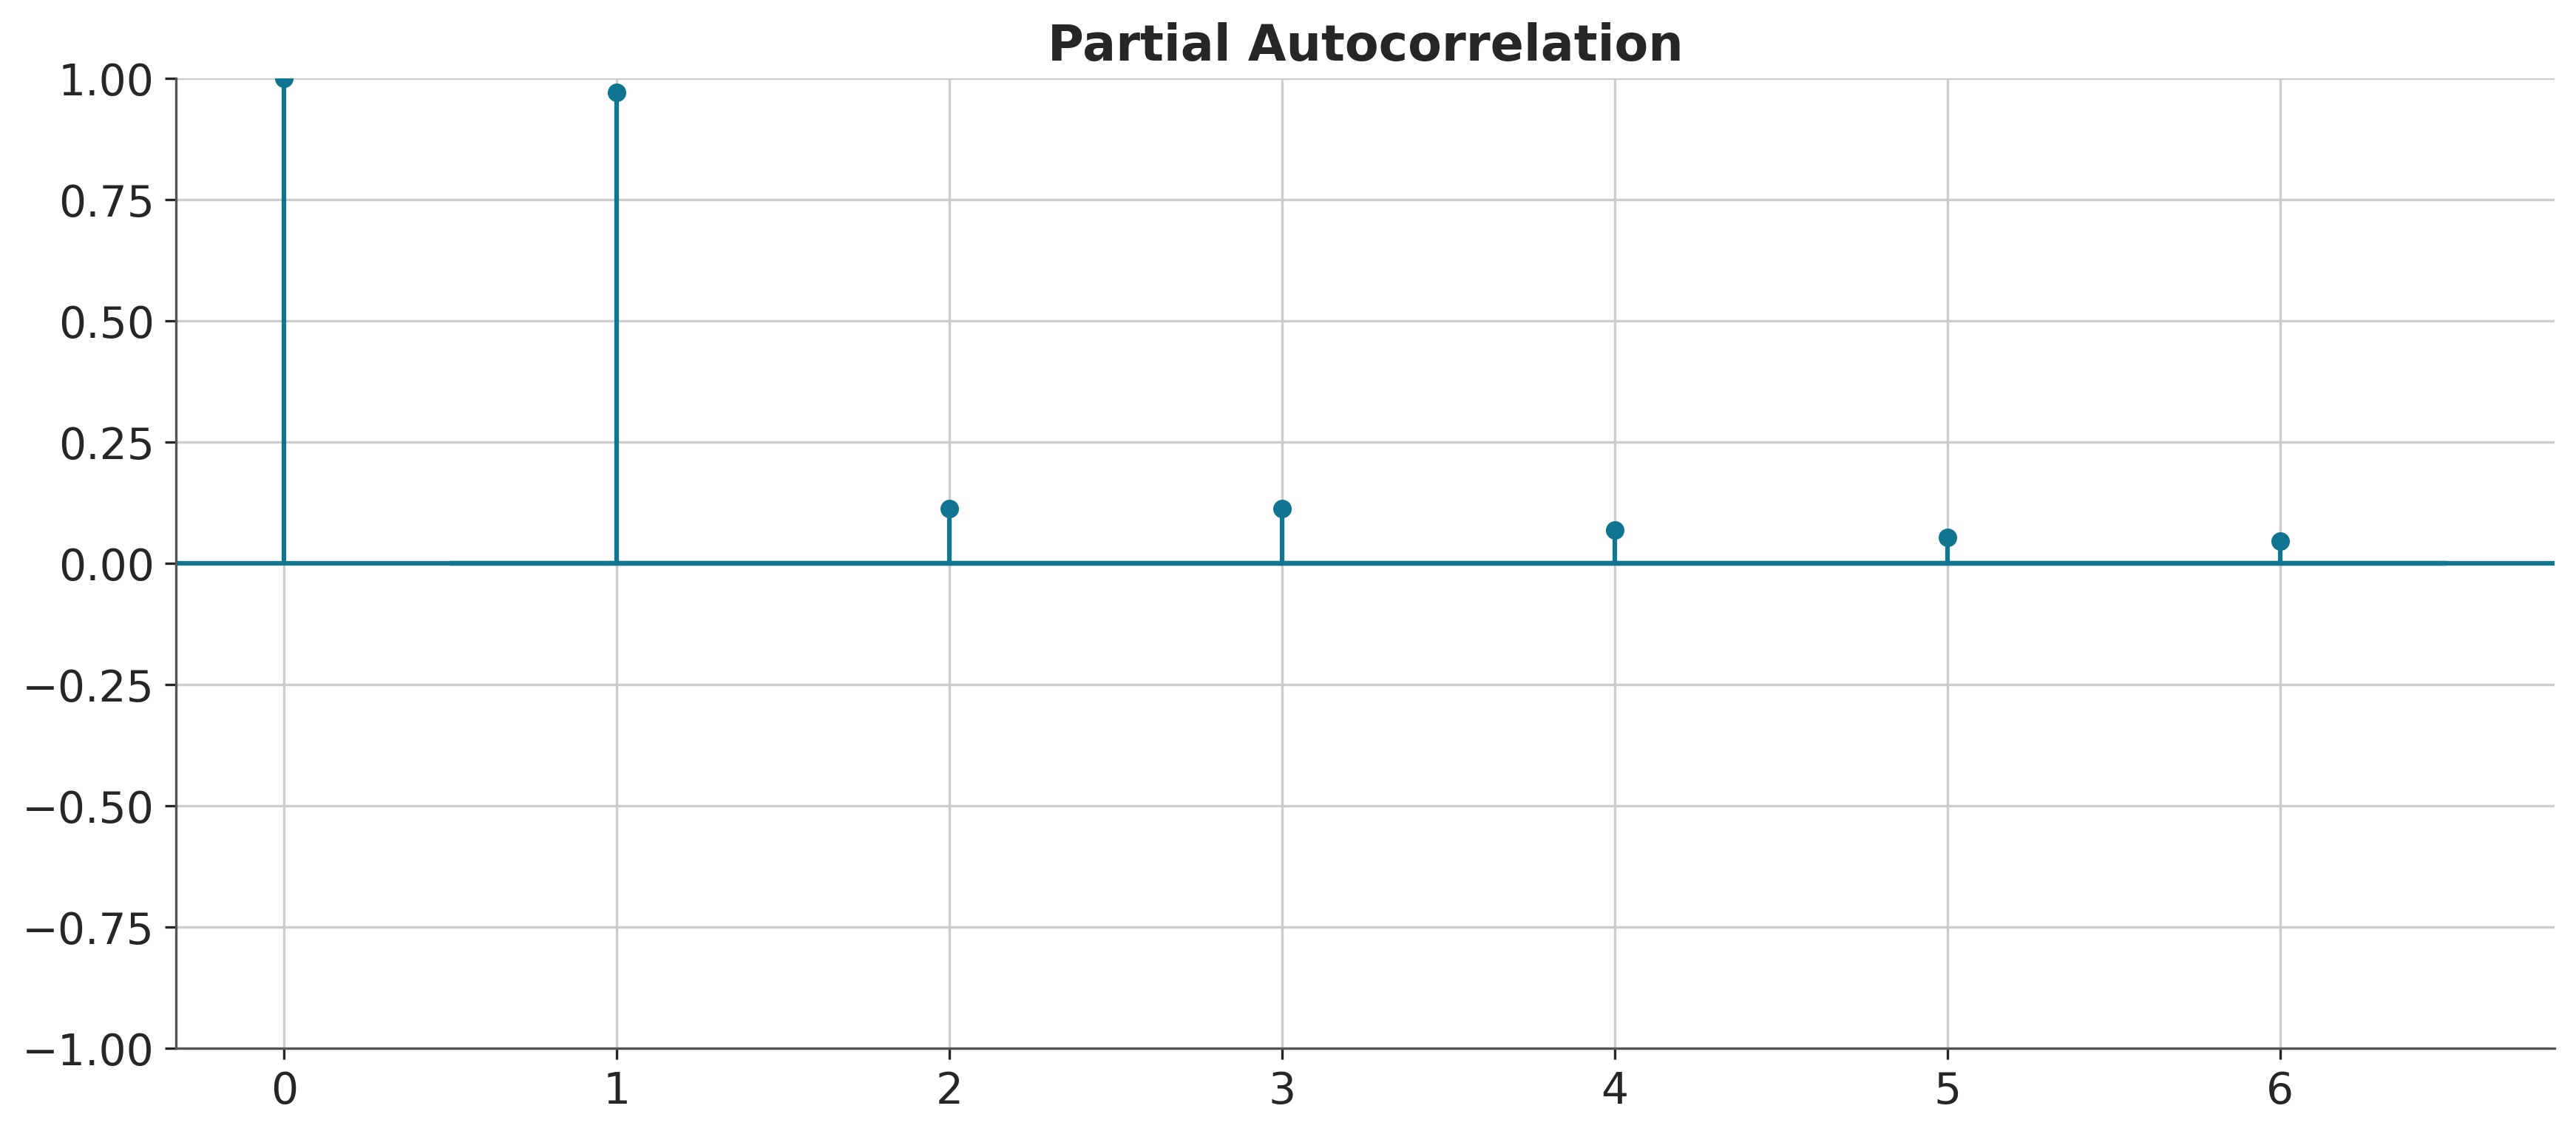

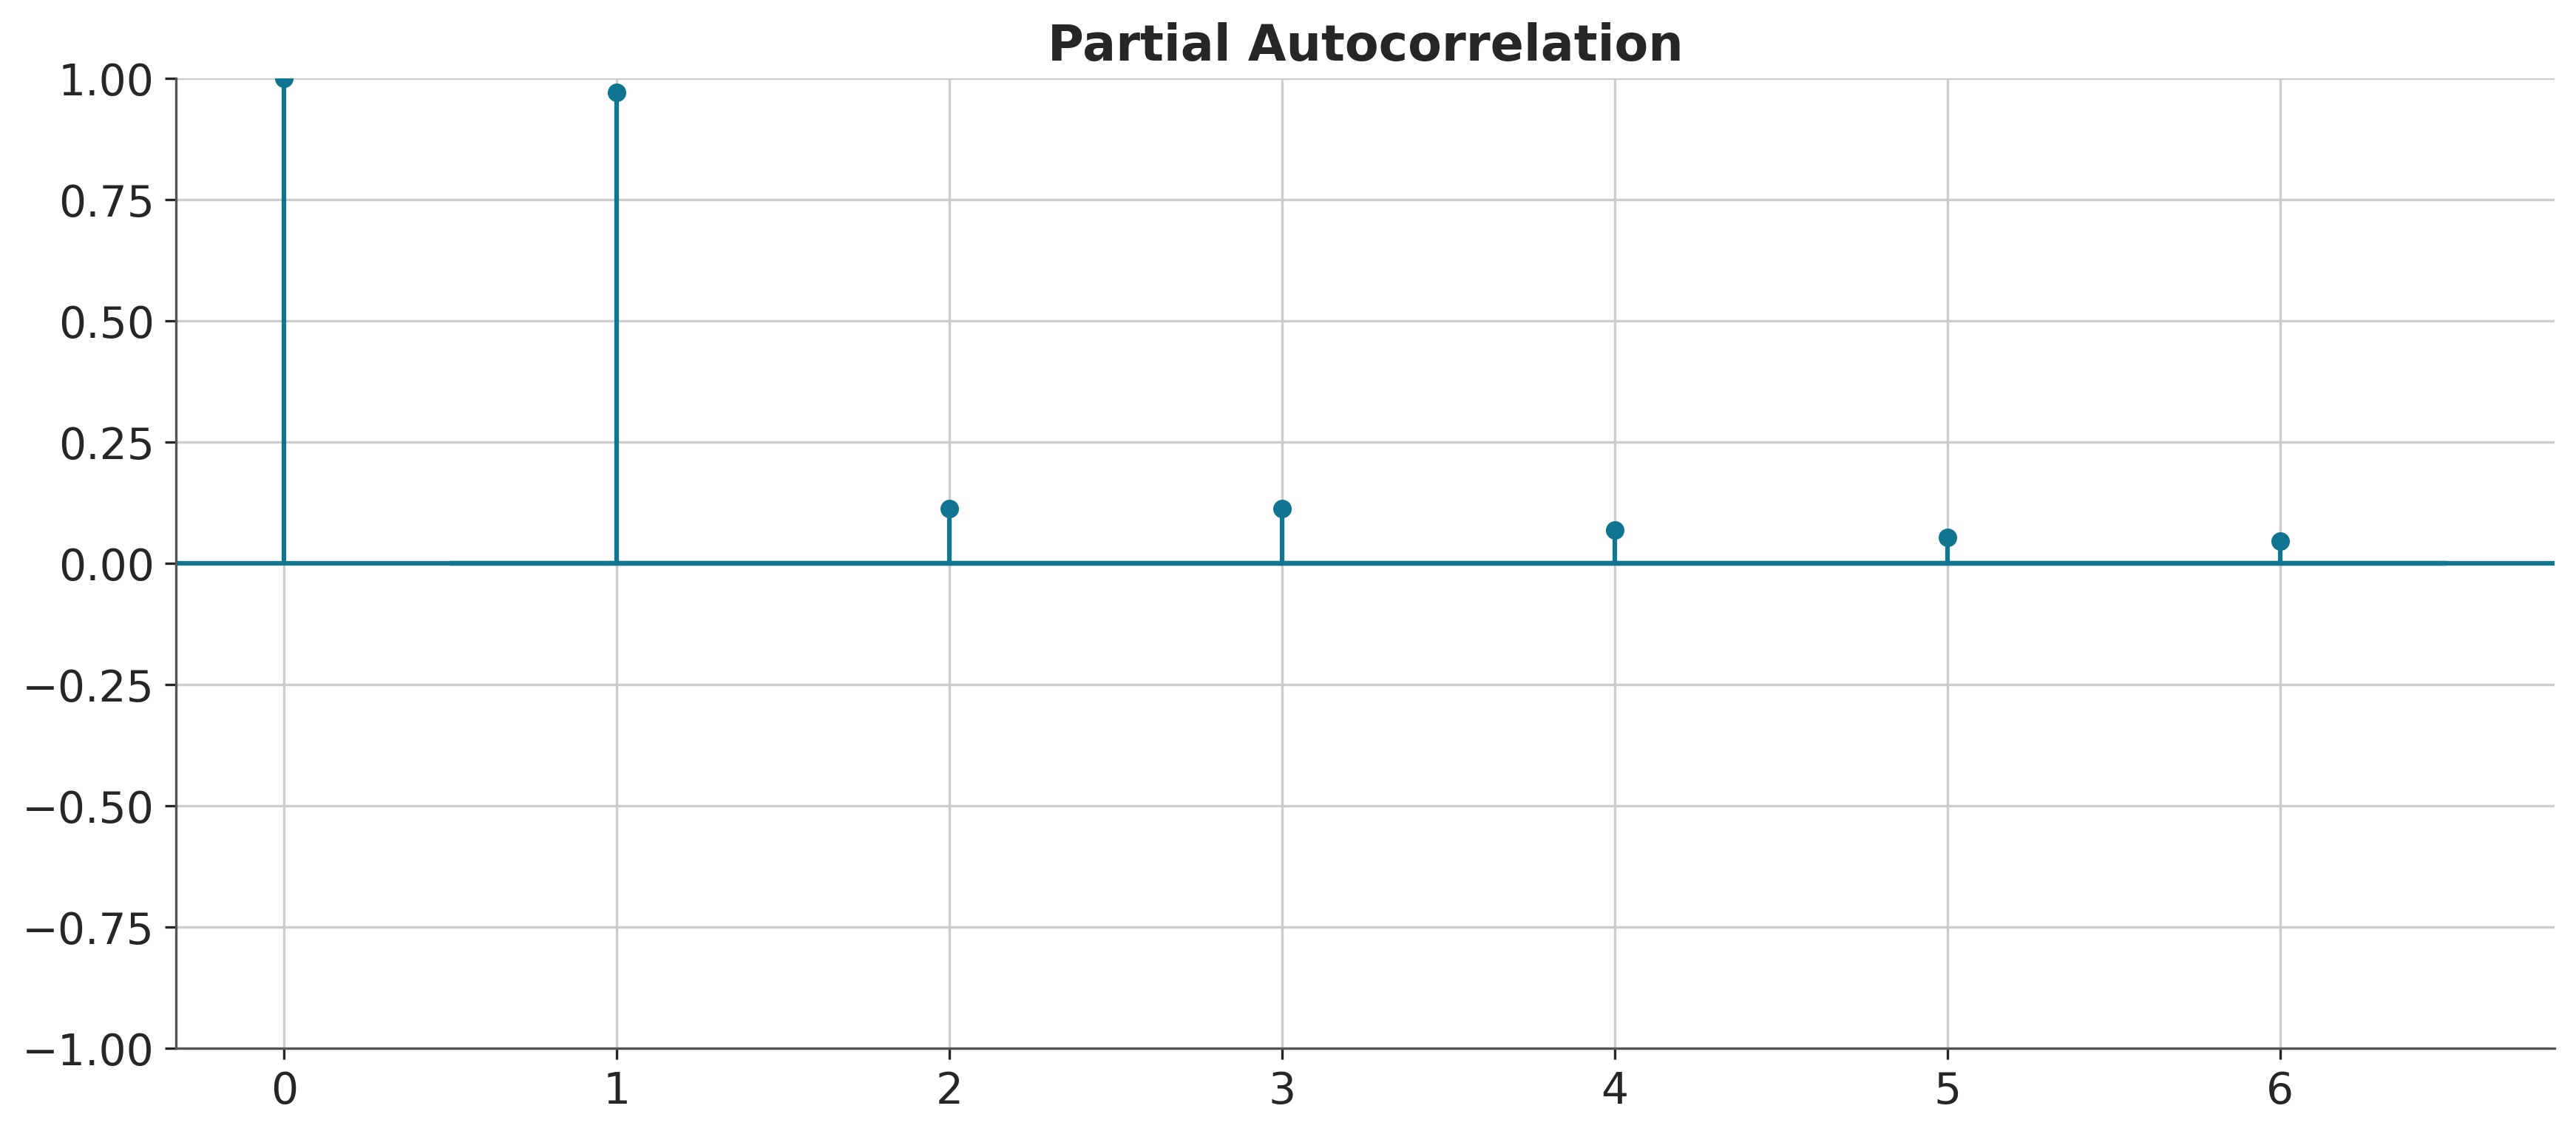

In [216]:
plot_pacf(wt["Power"], lags=6)

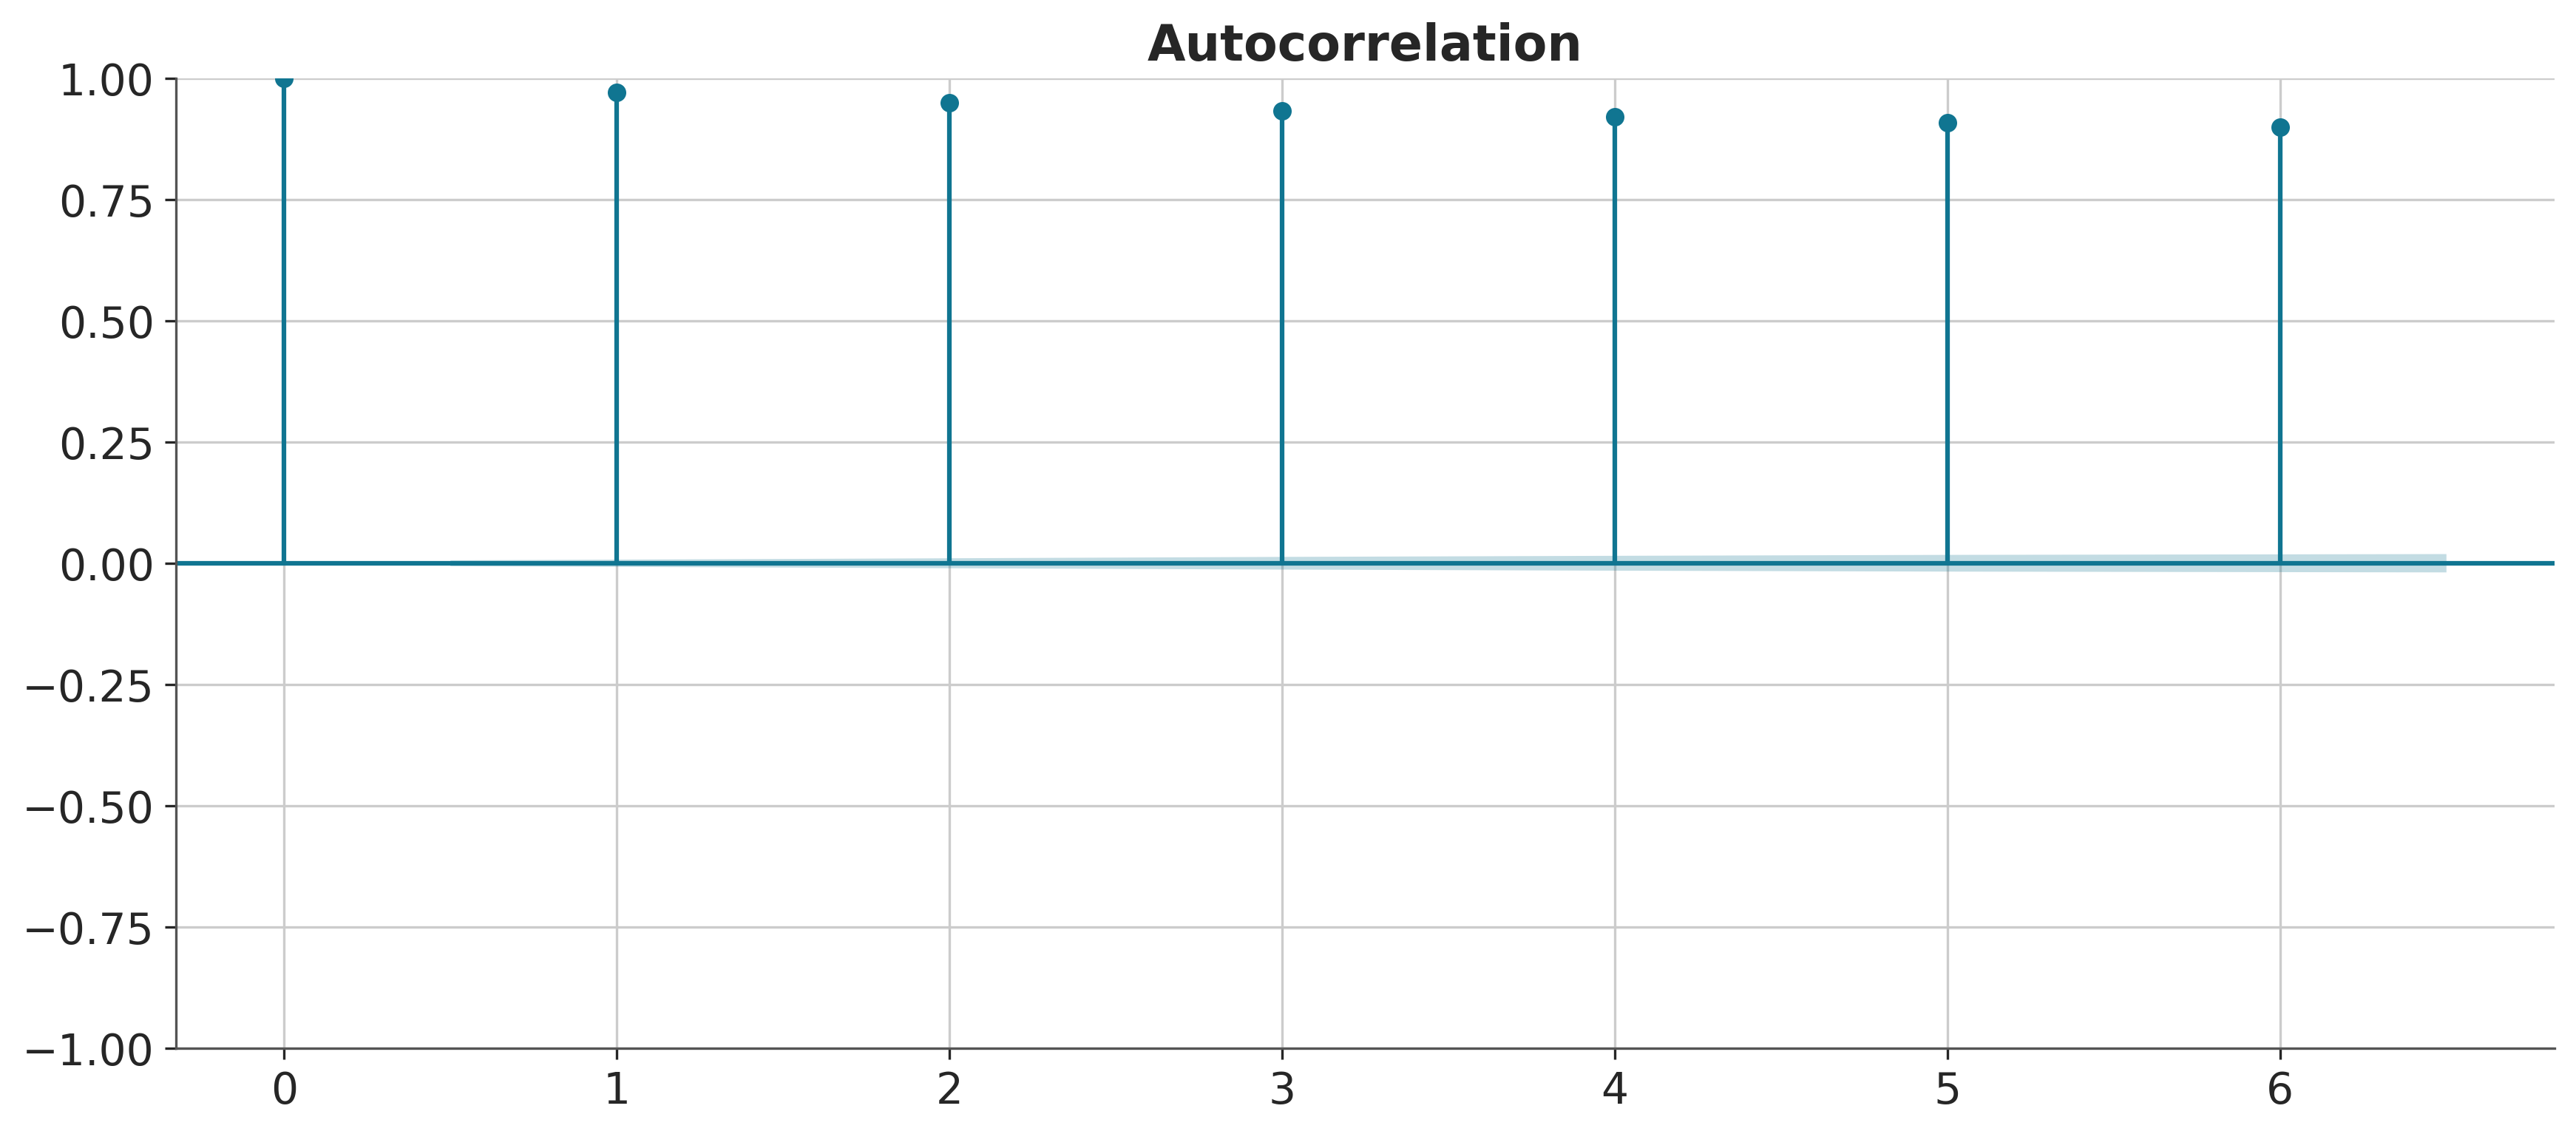

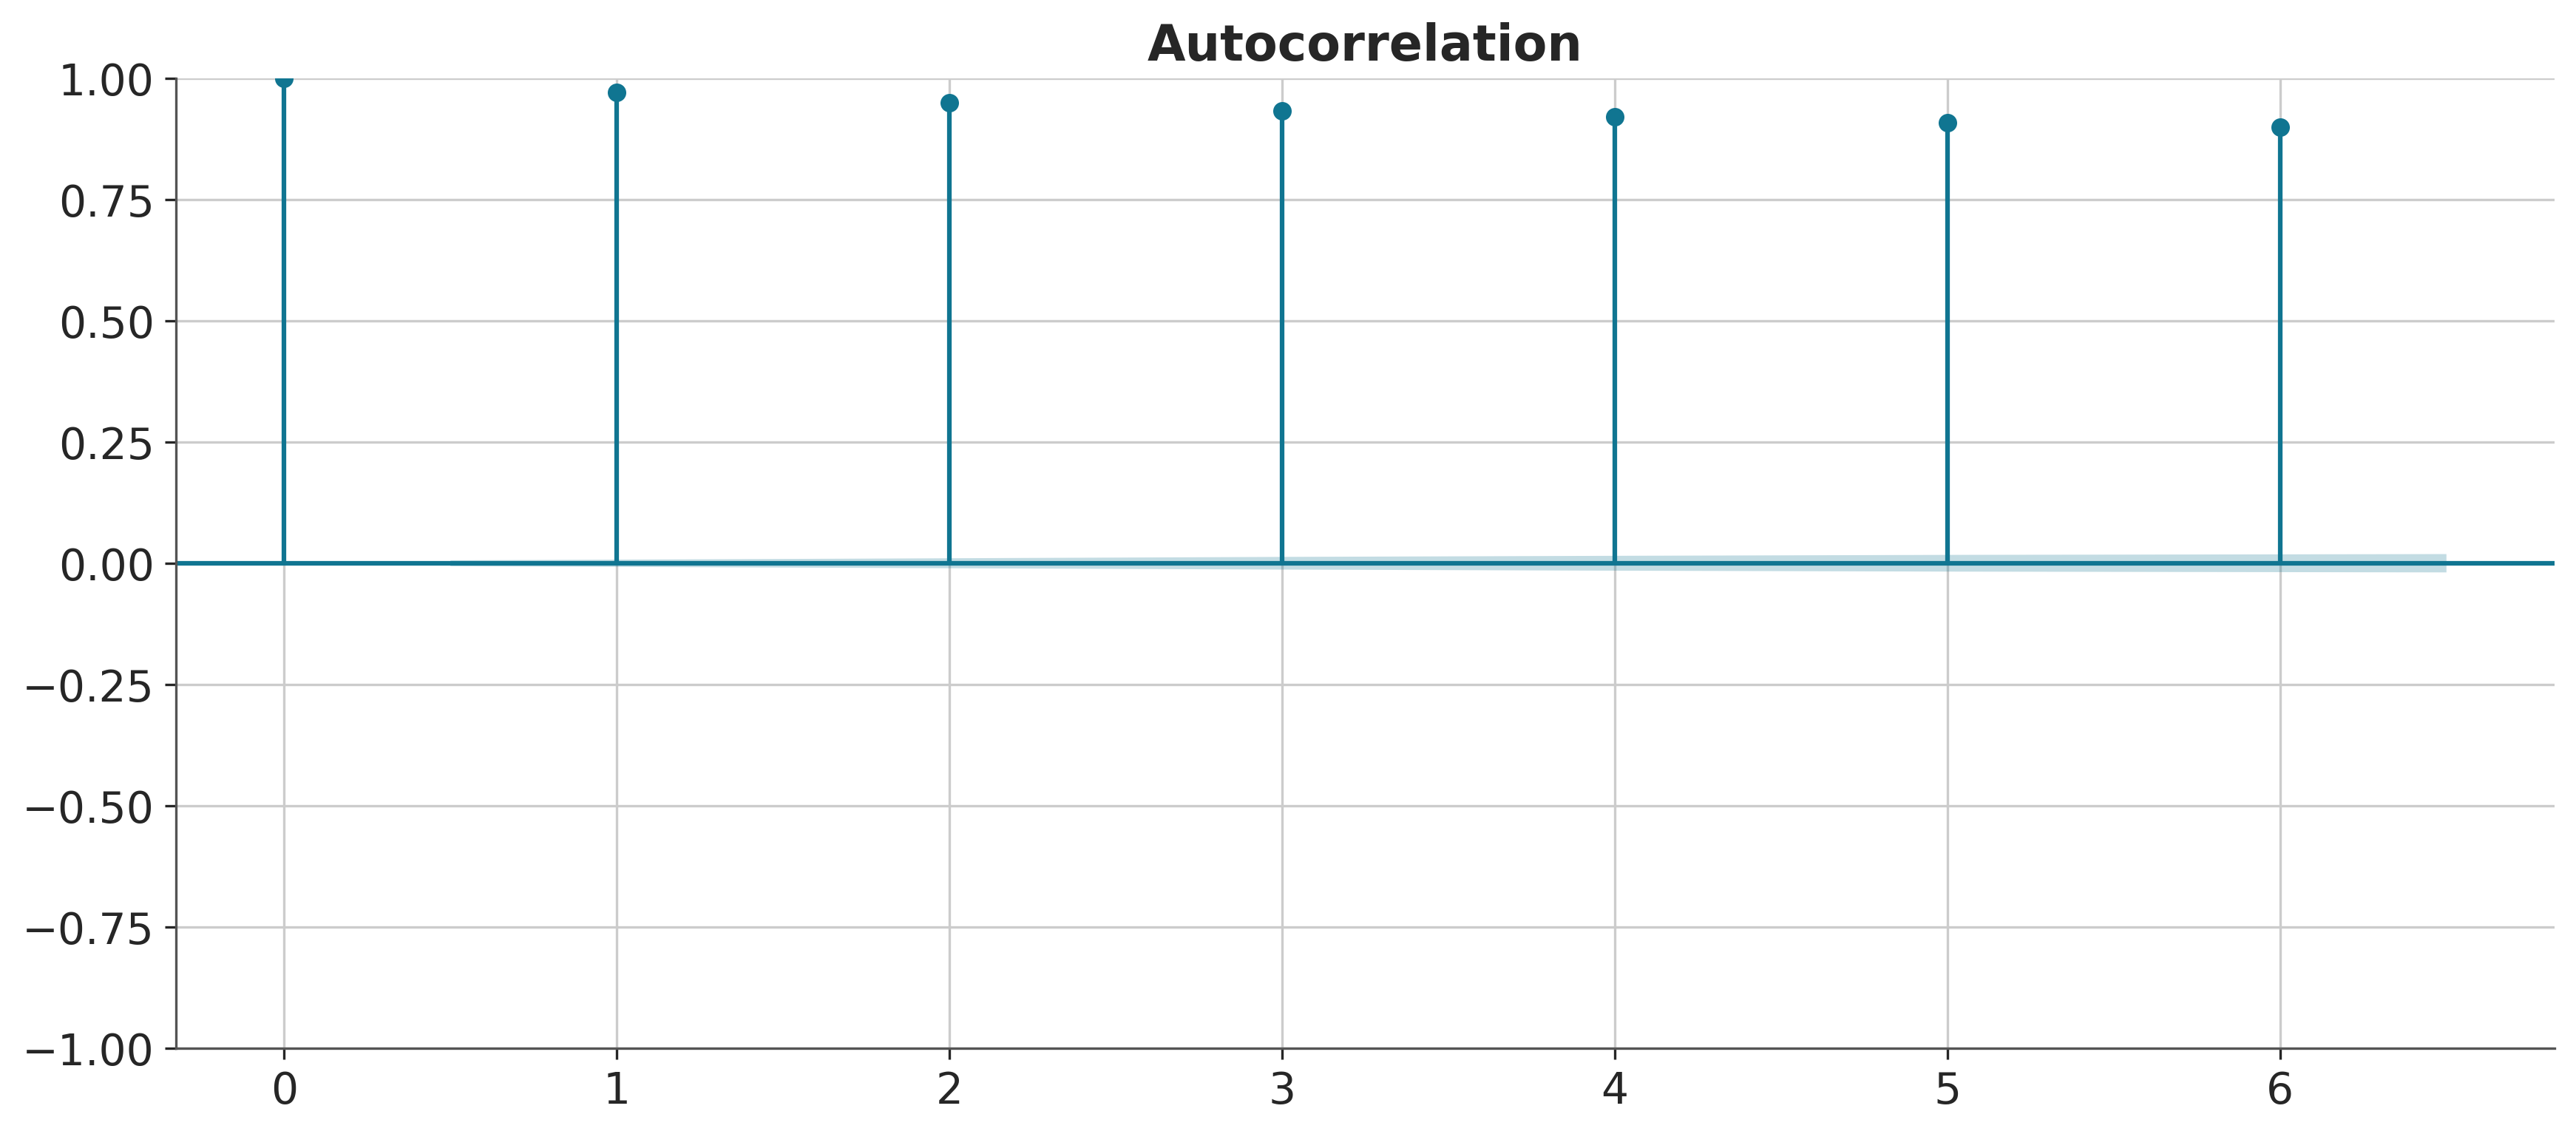

In [217]:
plot_acf(wt["Power"], lags=6)

## First approach: Autoregressive (AR) forecasting (Ridge)

With a multi-step AR approach, we can use the same data to predict any number of steps into the future. This approach is appropriate because wind power is highly autocorrelated. Specifically, this project uses a recursive autoregressive approach, in which a prediction of timestep $t$ uses the prediction from $t-1$ as an input, and so on in a recursive manner. This is further explained in the package used, [Skforecast](https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/autoregresive-forecaster.html). Skforecast provides utility methods for forecasting using scikit-learn. The downside of this approach is that it quickly breaks down in longer time horizons, as recursive prediction accumulates error.

In [218]:
y = wt["Power"].asfreq("10T")
y_train = y[y.index < "01-01-2020"]
y_test = y[(y.index >= "01-01-2020")]

#### Random Forest

In [219]:
rf = RandomForestRegressor(oob_score=True, random_state=123)

forecaster = ForecasterAutoreg(regressor=rf, lags=6)
            
forecaster.fit(y=y_train)
forecaster

KeyboardInterrupt: 

A quick look at a predicting the first hour of the test set shows a promising result with relatively low MAE.

In [ ]:
predictions = forecaster.predict(steps=6)
y_true = y_test[:6]

np.mean(abs(y_true - predictions))

This model can be more rigorously tested using [backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/backtesting.html), a cross-validation technique suited for time series data (_note: A typical k-folds cross validation technique here would cause data leakage, as some folds will end up incorporating future information into training, which is unrealistic!_). While backtesting without refitting is faster, a refitting backtest with fixed/variable training size would likely be more applicable: in a production system, it may be beneficial to refit the model to capture changing output patterns over time.

This backtest examines the error resulting from a model that predicts 1 hour (6 steps) forward. It does not refit, meaning that it only trains once, then runs against the test data. It outputs the MAE of the predictions against the observed power values.

In [ ]:
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = y,
    initial_train_size = len(y_train),
    fixed_train_size   = False,
    steps              = 6,
    metric             = "mean_absolute_error",
    refit              = False,
    verbose            = False
)

In [ ]:
metric

In [ ]:
# RMSE
mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)

In [ ]:
forecaster.get_feature_importance()

A glance at a 2 month slice of the results shows that the model appears to fit well, but underpredicts when large spikes/drops in power occur.

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
y_train[y_train.index >= "12-01-2019"].plot(ax=ax, label="train")
y_test[y_test.index < "02-01-2020"].plot(ax=ax, label="test")
predictions[predictions.index < "02-01-2020"].plot(ax=ax, label="predictions")
ax.set_ylabel("Power (kW)")
ax.set_ymargin(0)
ax.legend();

#fig.savefig("rf_multi.png")

#### Hyperparameter Tuning

_TODO: This may need to be run on a dedicated server, or the training/testing sets need to be made smaller._

In [ ]:
# y_train = y[y.index < "01-01-2020"]
# y_validation = y[(y.index >= "01-01-2020") & (y.index < "06-01-2020")]
# y_test = y[(y.index >= "06-01-2020")]

# rf = RandomForestRegressor(oob_score=True)
# forecaster = ForecasterAutoreg(regressor=rf, lags=6)

# # Lags used as predictors
# lags_grid = [3, 6, 12]

# # Regressor's hyperparameters
# param_grid = {'n_estimators': [100, 300, 500]}

# results_grid = grid_search_forecaster(
#                         forecaster         = forecaster,
#                         y                  = y[:"03-01-2020"],
#                         param_grid         = param_grid,
#                         lags_grid          = lags_grid,
#                         steps              = 6,
#                         refit              = False,
#                         metric             = 'mean_squared_error',
#                         initial_train_size = len(y_train),
#                         fixed_train_size   = False,
#                         return_best        = True,
#                         verbose            = False
#                )

#### Linear (Ridge)

In [ ]:
linear_forecaster = ForecasterAutoreg(
    regressor = Ridge(random_state=123),
    lags=6,
    transformer_y = StandardScaler()
)
            
linear_forecaster.fit(y=y_train)
linear_forecaster

In [ ]:
metric, predictions = backtesting_forecaster(
    forecaster         = linear_forecaster,
    y                  = y,
    initial_train_size = len(y_train),
    fixed_train_size   = False,
    steps              = 6,
    metric             = "mean_absolute_error",
    refit              = False,
    verbose            = False
)

These results show that it matches, if not outperforms, the same approach using the RF regressor. It is possible that this data follows a pattern matching the more classical definition of autoregressive models, in that power output depends linearly on its past values. With this knowledge, it would be interesting to see how this approach compares to models like ARIMA in terms of performance. 

In [ ]:
metric

In [ ]:
mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)

The feature importance looks similar here, with the first lag being by far the most important. It is not quite as strong as it is in the RF regressor, however.

In [ ]:
linear_forecaster.get_feature_importance()

## Bayesian Approach

In standard regression, we model the power at a given time $y_t$ as a linear combination of its lagged values and parameter vector $\bm{\beta}$,

$$
y_t = \alpha + \beta_1 y_{t-1} + ... + \beta_n y_{t-n}
$$

In a Bayesian approach, we model $y_t$ as following a normal distribution with mean $\mu_t$ and standard deviation $\sigma$,

$$
\begin{align}
y_t & \sim \mathcal{N}(\mu_t, \sigma) \\

\mu_t & = \alpha + \beta_1 y_{t-1} + ... + \beta_n y_{t-n} \\

\alpha & \sim \mathcal{N}(0, 10) \\
\beta & \sim \mathcal{N}(0, 1) \\
\sigma & \sim \text{Exponential}(1) \\
\end{align}
$$

In [ ]:
power_data = wt["Power"][wt.index < "2019-01-02"]
power_data_pred = wt["Power"][(wt.index > "2019-01-02") & (wt.index < "2019-01-03")]
power_data_pred

In [ ]:
model_data = {
    "y": power_data.values,
    "N": len(power_data),
    "K": 2
}

In [ ]:
# specify locations of Stan program file and data
stan_file = "./models/power_ar.stan"

# instantiate a model; compiles the Stan program by default
model = CmdStanModel(stan_file=stan_file)

# obtain a posterior sample from the model conditioned on the data
fit = model.sample(chains=4, data=model_data)

In [ ]:
fit.summary()

In [ ]:
idata = az.from_cmdstanpy(posterior=fit)
idata

In [ ]:
az.plot_trace(idata)

In [ ]:
ppc_data = model_data.copy()
# ppc_data["steps"] = 6

stan_ppc_file = "./models/power_ar_ppc.stan"

model_ppc = CmdStanModel(stan_file=stan_ppc_file)

new_quantities = model_ppc.generate_quantities(data=ppc_data, mcmc_sample=fit)

In [ ]:
y_pred_mean = new_quantities.draws_pd().mean()

In [ ]:
fig, ax = plt.subplots()

ax.plot(power_data.index, power_data, label="Observed")
ax.plot(power_data.index, y_pred_mean, label="Predicted")
ax.legend()

In [ ]:
idata_ppc = az.from_cmdstanpy(posterior=new_quantities)